Demonstrate the use of a densely connected neural network, like the one we trained on the MNIST data set, for classifying stars in the M4 cluster using Gaia's measurements of stars' locations on the sky (right ascension and declination).  This is basically a repeat of what we covered in class, but this time I want you to even out the training set to include roughly equal numbers of M4 members and non-members.

In [1]:
import pandas as pd
import numpy as np

In [2]:
#loaing M4 cluster 
m4_df = pd.read_fwf('../data/NGC6121-1.dat', names=['source_id', 'ra', 'dec', 'phot_g_mean_mag'])
m4_df

,source_id,ra,dec,phot_g_mean_mag
0,6045504229661220736,245.99162,-26.34434,18.438
1,6045504981264184192,246.03035,-26.28057,18.769
2,6045508902585952640,245.88761,-26.24297,19.072
3,6045507180287440000,245.85343,-26.28453,18.495
4,6045503473747038464,245.87124,-26.34628,17.163
...,...,...,...,...
19503,6045337962873610240,245.13976,-27.09970,19.705
19504,6045298891556291712,245.48339,-27.19208,19.493
19505,6045305866578950784,245.69445,-27.06942,18.290
19506,6045303774938119808,245.80824,-27.07275,19.267


In [3]:
import matplotlib.pyplot as plt

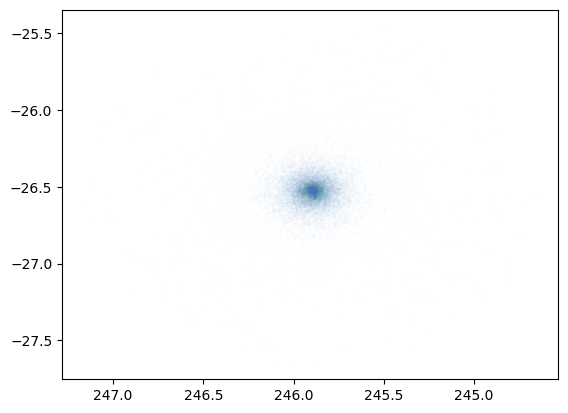

In [4]:
plt.scatter(m4_df.ra, m4_df.dec, s=0.0001)
plt.gca().invert_xaxis()

In [5]:
#M4 cluster using Gaia's measurements of stars' locations on the sky
#3 degree x 3 degree box centered at `RA=246, dec=-26.5`
df = pd.read_csv('../data/m4_gaia_source.csv')

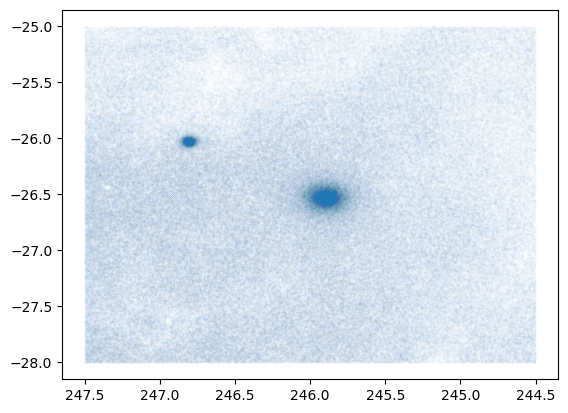

In [6]:
plt.scatter(df.ra, df.dec, s=0.0001)
plt.gca().invert_xaxis()

In [7]:
#classifying cluster members only from Gaia
m4_sel = df['source_id'].isin(m4_df.source_id)
print(np.count_nonzero(m4_sel))

19084


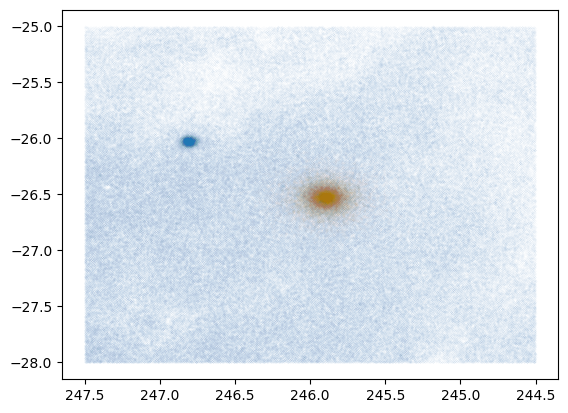

In [8]:
plt.scatter(df.ra[~m4_sel], df.dec[~m4_sel], s=0.0001)
plt.scatter(df.ra[m4_sel], df.dec[m4_sel], s=0.0001)
plt.gca().invert_xaxis()

In [9]:
#checking parameters inside the data to build a classifier based on sky position only
df.columns

Index(['designation', 'source_id', 'ra', 'dec', 'parallax', 'parallax_error',
       'parallax_over_error', 'pm', 'pmra', 'pmra_error', 'pmdec',
       'pmdec_error', 'astrometric_n_good_obs_al', 'astrometric_chi2_al',
       'visibility_periods_used', 'phot_g_mean_flux_over_error',
       'phot_g_mean_mag', 'phot_bp_mean_flux_over_error', 'phot_bp_mean_mag',
       'phot_rp_mean_flux_over_error', 'phot_rp_mean_mag',
       'phot_bp_rp_excess_factor', 'bp_rp', 'radial_velocity',
       'radial_velocity_error'],
      dtype='object')

In [10]:
#Gaia position or features are right ascension (ra) and declination (dec)
params = ['ra', 'dec']
X = np.array(df[params])
X.shape

(494996, 2)

In [11]:
np.count_nonzero(np.any(np.isnan(X), axis=1)) #checking for missing values

0

In [12]:
#when we start adding more columns we might miss values
# If there _were_ missing values, we would remove them like so
nans = np.any(np.isnan(X), axis=1) #identify rows with nan values
X = X[~nans] #remove rows with Nan values

n_classes = 2
y = m4_sel.astype(int)[~nans] #target vector for classification

In [13]:
X_m4 = X[y == 1]
X_non_m4 = X[y == 0]
y_m4 = y[y == 1]
y_non_m4 = y[y == 0]

In [14]:
from sklearn.utils import resample

In [15]:
#reducing number of non members M4
X_non_m4_resampled, y_non_m4_resampled = resample(X_non_m4, y_non_m4, 
                                                  n_samples=X_m4.shape[0],  # Match size of M4 members
                                                  random_state=42)

In [16]:
# Combine the resampled non-members with the M4 members
X_balanced = np.vstack([X_m4, X_non_m4_resampled])
y_balanced = np.hstack([y_m4, y_non_m4_resampled])

In [17]:
X_balanced

array([[244.65989404, -26.54591099],
       [244.72919817, -26.59846743],
       [244.75427727, -26.81094849],
       ...,
       [245.86865813, -26.415504  ],
       [247.33565793, -27.90479434],
       [246.87264625, -26.72568752]])

In [33]:
y_balanced

array([1, 1, 1, ..., 0, 0, 0])

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
# Step 3: Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

In [20]:
#normalizing input feature/ standarizing with mean 0

from sklearn.preprocessing import StandardScaler
transformer = StandardScaler()

X = transformer.fit_transform(X)

In [21]:
#using 10% data for testing and rest of them for training
m = X.shape[0]
test_frac = 0.1
test_sel = np.random.choice([True, False], size=m, p=[test_frac, 1-test_frac])
X_tst = X[test_sel]
X_train = X[~test_sel]

y_tst = y[test_sel]
y_train = y[~test_sel]

In [22]:
import jax
import jax.numpy as jnp

In [23]:
X_train = jnp.array(X_train)
X_tst = jnp.array(X_tst)
y_train = jnp.array(y_train)
y_tst = jnp.array(y_tst)

In [24]:
print(sum(y_train))
print(len(y_train)) 
#length of y train is longer than the sum of elements which means there is many empty elements.

17225
445821


In [25]:
print(np.any(np.isnan(y_train)))  # Should print False if there are no NaN values
print(np.count_nonzero(y_train == 0), np.count_nonzero(y_train == 1))  


False
428596 17225


In [26]:
#y_train_clean = [x for x in y_train if x != 0 and x is not None]
#print(len(y_train_clean))  # New length without empty elements
#print(sum(y_train_clean))  # Sum after removing empty elements


In [27]:
#neural network design
batch_size = 64
n_batches = X_train.shape[0] // batch_size

X_train = X_train[:n_batches * batch_size].reshape((n_batches, batch_size, *X_train.shape[1:]))
y_train = y_train[:n_batches * batch_size].reshape((n_batches, batch_size, *y_train.shape[1:]))
X_train.shape, y_train.shape

((6965, 64, 2), (6965, 64))

In [28]:
from flax import linen as nn

In [29]:
#model training
n_classes = 2

class DenseClassifier(nn.Module):
    """A simple dense classifier."""

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(n_classes)(x)
        return x

In [30]:
#summary of the model
dummy_input = jnp.ones((1, 2))
dnn = DenseClassifier()
print(dnn.tabulate(jax.random.PRNGKey(0), dummy_input))


                            DenseClassifier Summary                            
┌─────────┬─────────────────┬───────────────┬───────────────┬─────────────────┐
│ path    │ module          │ inputs        │ outputs       │ params          │
├─────────┼─────────────────┼───────────────┼───────────────┼─────────────────┤
│         │ DenseClassifier │ float32[1,2]  │ float32[1,2]  │                 │
├─────────┼─────────────────┼───────────────┼───────────────┼─────────────────┤
│ Dense_0 │ Dense           │ float32[1,2]  │ float32[1,10] │ bias:           │
│         │                 │               │               │ float32[10]     │
│         │                 │               │               │ kernel:         │
│         │                 │               │               │ float32[2,10]   │
│         │                 │               │               │                 │
│         │                 │               │               │ 30 (120 B)      │
├─────────┼─────────────────┼──────────

In [31]:
X_train.shape, y_train.shape

((6965, 64, 2), (6965, 64))

In [32]:
from clu import metrics
from flax.training import train_state
from flax import struct
import optax

ModuleNotFoundError: No module named 'clu'

In [ ]:
#we have 162 trainable parameter
#Training

@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

class TrainState(train_state.TrainState):
   metrics: Metrics

In [ ]:
def create_train_state(model, rng, learning_rate):
    params = model.init(rng, dummy_input)['params']
    tx = optax.adam(learning_rate)
    return TrainState.create(
        apply_fn=model.apply, params=params, tx=tx,
        metrics=Metrics.empty())

In [ ]:
@jax.jit
def train_step(state, batch, label):
  """Train for a single step."""
  def loss_fn(params):
    logits = state.apply_fn({'params': params}, batch)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=label).mean()
    return loss
  grad_fn = jax.grad(loss_fn)
  grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state

In [ ]:
@jax.jit
def compute_metrics(*, state, batch, label):
    logits = state.apply_fn({'params': state.params}, batch)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=label).mean()
    metric_updates = state.metrics.single_from_model_output(
        logits=logits, labels=label, loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [ ]:
init_rng = jax.random.PRNGKey(0)

learning_rate = 0.01

state = create_train_state(dnn, init_rng, learning_rate)
del init_rng  # Must not be used anymore.

In [ ]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [ ]:
n_epochs = 50

In [ ]:
step = 0

for _ in range(n_epochs):
  for batch, label in zip(X_train, y_train):

    # Run optimization steps over training batches and compute batch metrics
    state = train_step(state, batch, label) # get updated train state (which contains the updated parameters)
    state = compute_metrics(state=state, batch=batch, label=label) # aggregate batch metrics

    if (step+1) % n_batches == 0: # one training epoch has passed
      for metric,value in state.metrics.compute().items(): # compute metrics
        metrics_history[f'train_{metric}'].append(value) # record metrics
      state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

      # Compute metrics on the test set after each training epoch
      test_state = state
      test_state = compute_metrics(state=test_state, batch=X_tst, label=y_tst)

      for metric,value in test_state.metrics.compute().items():
        metrics_history[f'test_{metric}'].append(value)

      print(f"train epoch: {(step+1) // n_batches}, "
            f"loss: {metrics_history['train_loss'][-1]}, "
            f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
      print(f"test epoch: {(step+1) // n_batches}, "
            f"loss: {metrics_history['test_loss'][-1]}, "
            f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")
    step += 1

train epoch: 1, loss: 0.07641714811325073, accuracy: 96.17352294921875
test epoch: 1, loss: 0.22396628558635712, accuracy: 96.17521667480469
train epoch: 2, loss: 0.07604709267616272, accuracy: 96.18452453613281
test epoch: 2, loss: 0.18641060590744019, accuracy: 96.17521667480469
train epoch: 3, loss: 0.07603079825639725, accuracy: 96.19438934326172
test epoch: 3, loss: 0.09847143292427063, accuracy: 96.17521667480469
train epoch: 4, loss: 0.07601537555456161, accuracy: 96.19215393066406
test epoch: 4, loss: 0.1353512704372406, accuracy: 96.17521667480469
train epoch: 5, loss: 0.07600440084934235, accuracy: 96.1964111328125
test epoch: 5, loss: 0.12065904587507248, accuracy: 96.17521667480469
train epoch: 6, loss: 0.076024629175663, accuracy: 96.19686126708984
test epoch: 6, loss: 0.09469825774431229, accuracy: 96.17521667480469
train epoch: 7, loss: 0.07601188123226166, accuracy: 96.19169616699219
test epoch: 7, loss: 0.08548411726951599, accuracy: 96.17521667480469
train epoch: 8, l

In [ ]:
import matplotlib.pyplot as plt

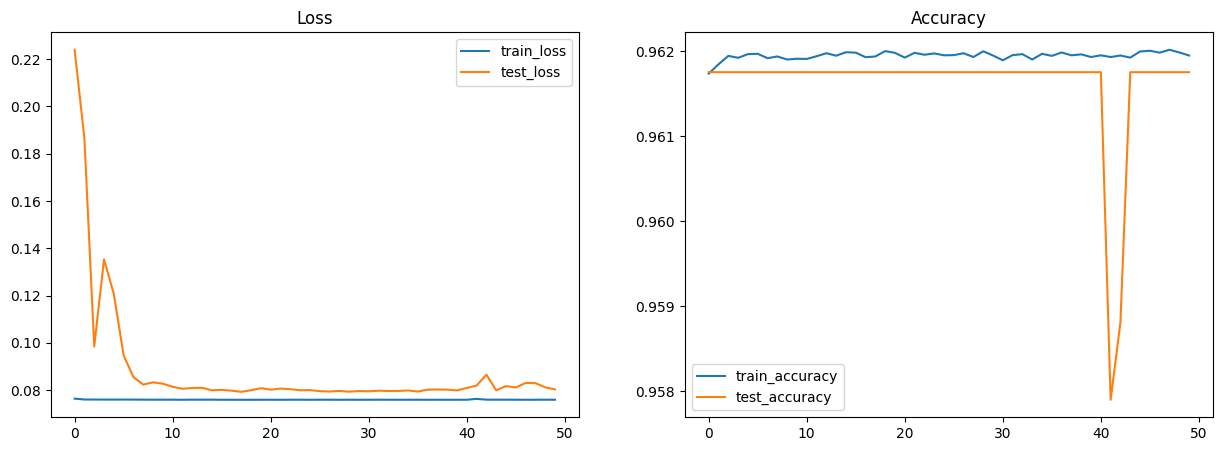

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

Q1.What training and validation accuracies are you able to achieve?

In [ ]:
#checking classifier
@jax.jit
def pred_step(state, batch):
  logits = state.apply_fn({'params': state.params}, batch)
  return logits.argmax(axis=1)

pred = pred_step(state, X_tst)
pred

Array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

(array([    0.,     0.,     0.,     0.,     0., 49310.,     0.,     0.,
            0.,     0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

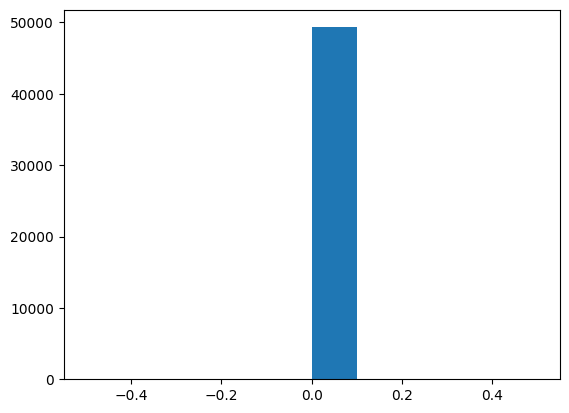

In [ ]:
plt.hist(pred)

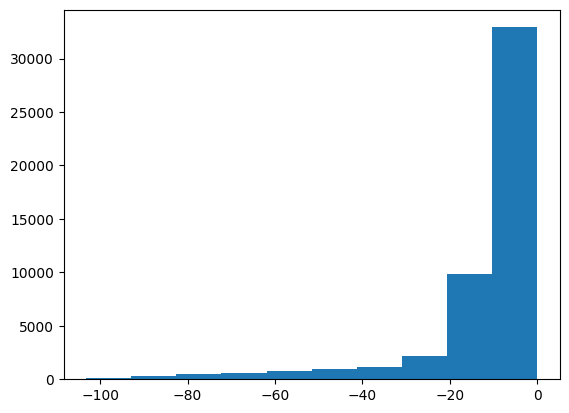

In [ ]:
#difference (remember these are "log"its) of the values from the output nodes to see 
# if it's picking up hints of something useful
outputs = state.apply_fn({'params': state.params}, X_tst)
plt.hist(jnp.diff(outputs, axis=1).flatten());

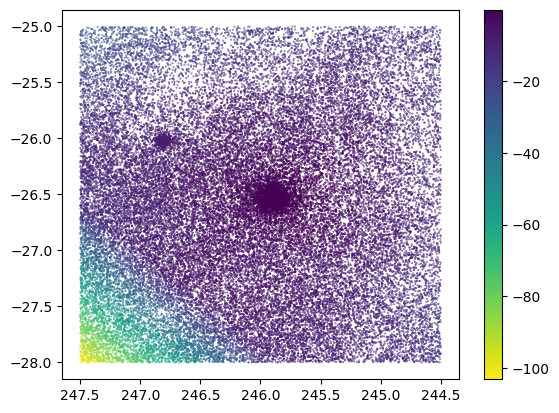

In [ ]:
plt.scatter(df.ra[~nans][test_sel], df.dec[~nans][test_sel], c=jnp.diff(outputs, axis=1), s=.1, cmap='viridis_r')
plt.colorbar()

plt.gca().invert_xaxis()